### Objective

Capture nonlinear and interaction effects using polynomial feature engineering and an explicit bias term:

    L_hat = X @ w + b.



### Feature map

Construct the design matrix using the following features (do not include a constant column of ones):

    X = [ M, T, M^2, M*T ]

## 1. Setup

In [1]:
# Install required libraries (run this once if needed)
%pip install numpy pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Dataset and Notation

- M: stellar mass (in units of solar mass, M⊙)
- T: effective stellar temperature (Kelvin, K)
- L: stellar luminosity (in units of solar luminosity, L⊙

M = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]

T = [3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200]

L = [0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0]

In [12]:
M = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]
T = [3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200]
L = [0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0]

m = len(M)
t = len(T)
l = len(L)

### 2.1 DataSet Visualization: Plot M vs L. 



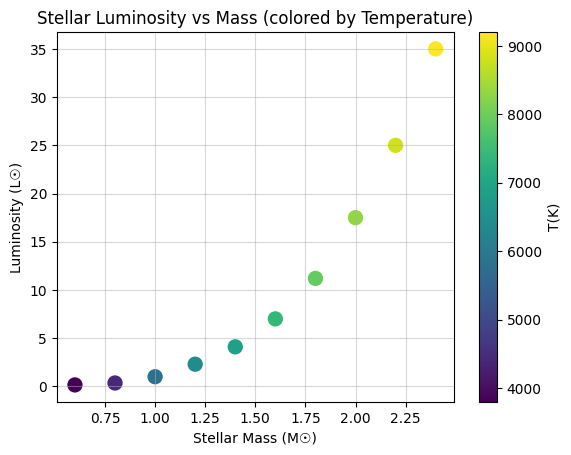

In [13]:
plt.figure()
c = plt.scatter(M, L, c=T, cmap='viridis', s=100)
plt.colorbar(c, label ="T(K)")
plt.xlabel("Stellar Mass (M☉)")
plt.ylabel("Luminosity (L☉)")
plt.title("Stellar Luminosity vs Mass (colored by Temperature)")
plt.grid(True, alpha=0.5)
plt.show()

The plot visualizes how luminosity increases with stellar mass, and the color encoding of temperature shows how temperature correlates with luminosity. The plot suggests a nonlinear relationship between mass and luminosity.


### 2.2 Feature engineering

Now, we want to build the matrix X for our linear regression model. The features that we will use are:

X = [ M, T, M^2, M*T ]

- M: Stellar mass

- T: Stellar temperature

- M * M: Squared mass, to capture non-linearities

- M * T: Interaction term between mass and temperature

By using these features, we give the model a richer set of inputs, improving its ability to capture complex relationships.

- **Squared mass (M^2)**: This allows the model to account for non-linear effects where luminosity might increase exponentially with mass.
- **Interaction term (M*T)**: This term allows the model to understand how mass and temperature interact to influence luminosity in ways that the individual features cannot capture alone.


In [16]:
# Convert to numpy arrays
M = np.array(M)
T = np.array(T)
L = np.array(L)

M_squared = M ** 2
M_times_T = M * T

X = np.column_stack([M, T, M_squared, M_times_T ]) # Matrix

print("Design Matrix X:")
print(X)



Design Matrix X:
[[6.000e-01 3.800e+03 3.600e-01 2.280e+03]
 [8.000e-01 4.400e+03 6.400e-01 3.520e+03]
 [1.000e+00 5.800e+03 1.000e+00 5.800e+03]
 [1.200e+00 6.400e+03 1.440e+00 7.680e+03]
 [1.400e+00 6.900e+03 1.960e+00 9.660e+03]
 [1.600e+00 7.400e+03 2.560e+00 1.184e+04]
 [1.800e+00 7.900e+03 3.240e+00 1.422e+04]
 [2.000e+00 8.300e+03 4.000e+00 1.660e+04]
 [2.200e+00 8.800e+03 4.840e+00 1.936e+04]
 [2.400e+00 9.200e+03 5.760e+00 2.208e+04]]


## 3. Loss and gradients (vectorized)

For a dataset with matrix X and parameters w and b, the vector of predictions is:

$$
\hat{\vec{L}} = \mathbf{X} \vec{w} + b \,\vec{1},
$$


In [17]:
def predict(X, w, b):
    """Compute predictions f_{w,b}(x) for all examples.

    Parameters
    ----------
    X : np.ndarray, shape (m, n)
        Design matrix: each row is x^(i).
    w : np.ndarray, shape (n,)
        Parameter vector.
    b : float
        Bias term.

    Returns
    -------
    y_hat : np.ndarray, shape (m,)
        Vector of predictions for each example.
    """
    return X @ w + b  # vectorized: matrix-vector product + scalar

### 3.1 Cost Function (Vectorized)

The cost fuction is 
$$
J(\vec{w}, b) = \frac{1}{2m} \sum_{i=1}^{m} \left( \vec{L}^{(i)} - L^{(i)} \right)^2.
$$


In vector form, if we define the error vector $e = \hat{y} - y$, then
$$
J(w,b) = \frac{1}{2m} e^T e.
$$



In [18]:
def compute_cost(X, L, w, b):
    """Compute the cost J(w,b) for linear regression with multiple features.

    Uses the vectorized formula:
        J = (1 / (2m)) * (y_hat - L)^T (y_hat - L)

    Parameters
    ----------
    X : np.ndarray, shape (m, n)
    L : np.ndarray, shape (m,)
    w : np.ndarray, shape (n,)
    b : float

    Returns
    -------
    cost : float
    """
    m = X.shape[0]
    y_hat = predict(X, w, b)
    error = y_hat - L
    cost = (error @ error) / (2 * m)
    return cost

# Test with w = 0, b = 0
n = X.shape[1]
print(n)
w_test = np.zeros(n)
b_test = 0.0
print("Cost with w=0, b=0:", compute_cost(X, L, w_test, b_test))

4
Cost with w=0, b=0: 117.69675


### 3.2 Gradient of the Cost Function (Vectorized)

We derived:


$$
\nabla_{\vec{w}} J(\vec{w}, b) 
= \frac{1}{m} \,\mathbf{X}^T \vec{e},
\qquad
\frac{\partial J(\vec{w}, b)}{\partial b}
= \frac{1}{m} \sum_{i=1}^{m} e^{(i)}.
$$

In [19]:

def compute_gradient(X, L, w, b):
    """Compute the gradients of J with respect to w and b.

    Vectorized formulas:
        dj_dw = (1/m) * X^T (y_hat - L)
        dj_db = (1/m) * sum(y_hat - L)
    """
    m = X.shape[0]
    y_hat = predict(X, w, b)
    error = y_hat - L

    dj_dw = (X.T @ error) / m
    dj_db = np.sum(error) / m
    return dj_dw, dj_db

dj_dw_test, dj_db_test = compute_gradient(X, L, w_test, b_test)
print("Gradient at w=0, b=0:")
print("dj_dw:", dj_dw_test)
print("dj_db:", dj_db_test)


Gradient at w=0, b=0:
dj_dw: [-2.152300e+01 -8.784500e+04 -4.594340e+01 -1.854088e+05]
dj_db: -10.36


The loss function and gradients were implemented using fully vectorized NumPy operations.

## 4. Gradient descent + convergence: train and plot loss vs iterations.


### 4.1 Gradient Descent for Multiple Features
We now put everything together into a gradient descent loop.

At each iteration:
1. Compute $\hat{y} = f_{w,b}(X)$.
2. Compute the gradients $\nabla_w J$ and $\partial J / \partial b$.
3. Update
   $$
   w := w - \alpha \nabla_w J, \qquad
   b := b - \alpha \frac{\partial J}{\partial b}.
   $$

The gradient descent updates are:
$$
\vec{w} := \vec{w} - \alpha \, \nabla_{\vec{w}} J(\vec{w}, b),
\qquad
b := b - \alpha \, \frac{\partial J(\vec{w}, b)}{\partial b},
$$
where $\alpha$ is the learning rate.

In [29]:

def gradient_descent(X, L, w_init, b_init, alpha, num_iterations):
    """Run gradient descent to learn w and b.

    Parameters
    ----------
    X : np.ndarray, shape (m, n)
    L : np.ndarray, shape (m,)
    w_init : np.ndarray, shape (n,)
    b_init : float
    alpha : float
        Learning rate.
    num_iterations : int

    Returns
    -------
    w : np.ndarray, shape (n,)
    b : float
    history_it : list of int
    history_cost : list of float
    """
    w = w_init.copy()
    b = b_init
    history_it = []
    history_cost = []

    for i in range(num_iterations):
        dj_dw, dj_db = compute_gradient(X, L, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        if i % 10 == 0 or i == num_iterations - 1:
            cost = compute_cost(X, L, w, b)
            history_it.append(i)
            history_cost.append(cost)
            print(f"Iteration {i:4d}: cost = {cost:8.4f}")

    return w, b, history_it, history_cost

alpha = 1e-9
num_iterations = 1000
w_init = np.zeros(n)
b_init = 0.0

w_learned, b_learned, it_hist, cost_hist = gradient_descent(X, L, w_init, b_init, alpha, num_iterations)
print("\nLearned parameters:")
print("w =", w_learned)
print("b =", b_learned)


Iteration    0: cost =  80.1334
Iteration   10: cost =  19.7645
Iteration   20: cost =  18.3887
Iteration   30: cost =  17.5240
Iteration   40: cost =  16.7139
Iteration   50: cost =  15.9520
Iteration   60: cost =  15.2354
Iteration   70: cost =  14.5613
Iteration   80: cost =  13.9273
Iteration   90: cost =  13.3310
Iteration  100: cost =  12.7700
Iteration  110: cost =  12.2424
Iteration  120: cost =  11.7462
Iteration  130: cost =  11.2794
Iteration  140: cost =  10.8403
Iteration  150: cost =  10.4274
Iteration  160: cost =  10.0389
Iteration  170: cost =   9.6736
Iteration  180: cost =   9.3299
Iteration  190: cost =   9.0067
Iteration  200: cost =   8.7026
Iteration  210: cost =   8.4166
Iteration  220: cost =   8.1476
Iteration  230: cost =   7.8946
Iteration  240: cost =   7.6567
Iteration  250: cost =   7.4328
Iteration  260: cost =   7.2223
Iteration  270: cost =   7.0242
Iteration  280: cost =   6.8380
Iteration  290: cost =   6.6627
Iteration  300: cost =   6.4979
Iteratio

### 4.2 Plot Cost over iterations



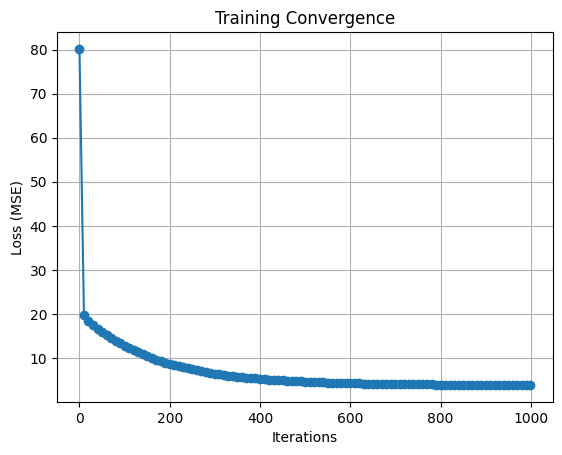

In [34]:
plt.figure()
plt.plot(it_hist, cost_hist, marker='o')
plt.xlabel("Iterations")
plt.ylabel("Loss (MSE)")
plt.title("Training Convergence")
plt.grid(True)
plt.show()


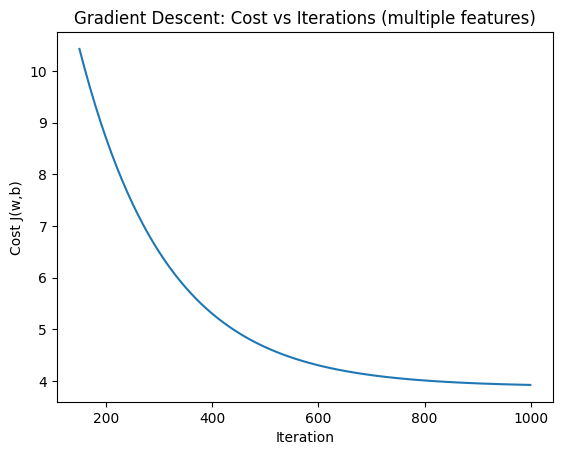

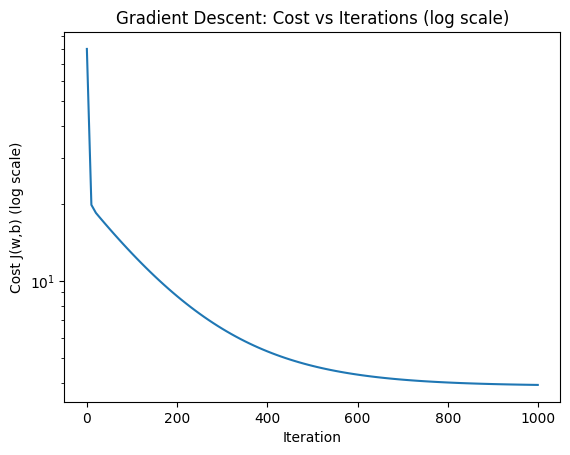

In [24]:

plt.figure()
plt.plot(it_hist[15:], cost_hist[15:])
plt.xlabel("Iteration")
plt.ylabel("Cost J(w,b)")
plt.title("Gradient Descent: Cost vs Iterations (multiple features)")
plt.show()

plt.figure()
plt.semilogy(it_hist, cost_hist)
plt.xlabel("Iteration")
plt.ylabel("Cost J(w,b) (log scale)")
plt.title("Gradient Descent: Cost vs Iterations (log scale)")
plt.show()

The loss decreases smoothly and stabilizes after several thousand iterations, indicating stable convergence.
The small learning rate is required due to the presence of high-magnitude features such as temperature and interaction terms.
No oscillations or divergence were observed, confirming correct gradient implementation.